# **Proyecto 2: Análisis de mercado inmobiliario**

## **Consigna**

En este proyecto profundizarás lo desarrollado en el proyecto 01. El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

El trabajo se organiza en tres partes:

### **PARTE A - Transformación de Datos**

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:

1. Detección y eliminación de Outliers
1. Encoding
1. Imputación de valores faltantes
1. Escalado de datos
1. Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

### **PARTE B - Modelos Avanzados**

1. Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.
1. Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.
1. Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

### **PARTE C - Interpretación de modelos**

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

* ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?
* ¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

### **DESAFÍO OPCIONAL**

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from dstools.eda import DataHandler
from dstools.modeling import RegressionModeling

from sklearn.cluster import KMeans

En primer lugar se mostraran los resultados de la parte 1 del proyecto.

In [294]:
properati = pd.read_csv('DS_Proyecto_02_Datos_Properati.csv')
data_handler = DataHandler(properati)
regression_modeling = RegressionModeling()

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 88274.0169560616
Raíz del error cuadrático medio en Test: 101609.9322862421



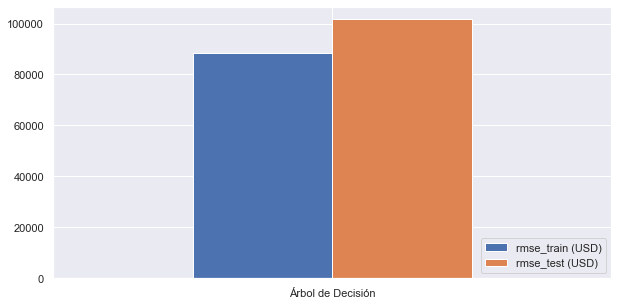

In [295]:
filters = {
    'reset_data': True,
    'fixed_values': {
        'property_type': ['Departamento', 'PH', 'Casa'],
        'l2': ['Capital Federal']
    },
    'columns': ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type', 'price'],
    'max_surface_total' : 1000,
    'min_surface_total' : 15,
    'max_lat': 60,
    'drop_invalid': True,
    'drop_missing': True,
    'max_price' : 4000000
}
data_handler.filter_data(**filters)
dataset = data_handler.processed_data.copy()

labelencoder = LabelEncoder()
dataset.property_type = labelencoder.fit_transform(dataset.property_type)
property_type_dummies = pd.get_dummies(dataset.property_type)
property_type_dummies.columns = labelencoder.classes_

dataset['Departamento'] = property_type_dummies['Departamento']
dataset.drop(['property_type'], axis=1, inplace=True)

dataset = dataset[dataset.bedrooms != 0]
dataset['bath_bed_ratio'] = dataset.bathrooms / dataset.bedrooms
dataset = dataset.drop(['bedrooms', 'bathrooms'], axis=1)

dataset = dataset.drop(['surface_total', 'rooms'], axis=1)

X = dataset.drop(['price'], axis=1)
y = dataset.price

models_info = { 'Árbol de Decisión': DecisionTreeRegressor(random_state=42, max_depth=9) }

regression_modeling.study_dataset(X, y, models_info, metric='rmse', plot_residuals=False, kde=False, plot_error_metrics=True)

regression_modeling.set_benchmark('Árbol de Decisión', print_errors=False)

# Suposiciones iniciales

Se seguira el mismo punto de partida que en la parte 1:

* **Region a analizar:** Capital Federal
* **Tipo de propiedades:** Departamento, PH y Casa

## Parte A - Transformacion de datos

Establecemos la semilla a usar en los pasos que dependan de un proceso aleatorio.

In [296]:
random_state = 2020-10-14

In [297]:
filters = {
    'reset_data': True
}
data_handler.filter_data(**filters)
dataset = data_handler.processed_data.copy()
dataset.operation_type.nunique()

1

In [298]:
dataset.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

Reiniciamos el dataset, filtramos por tipo de propiedad y descartamos los siguientes campos:

* **Fechas:** no se mediran influencias temporales en los precios de los inmuebles.
* **l1, currency y operation_type:** son campos con varianza cero a lo largo del dataset.
* **l2:** l2 y l3 pueden ser descartadas puesto que los campos de latitud y longitud contienen dicha informacion, sin embargo, l3 no se descarta en esta instancia para poder hacer un breve analisis de datos para lo que puede ser de utilidad.
* **title y description:** no se hara uso de tecnicas de NLP para obtener insights de los campos de texto.

In [299]:
filters = {
    'reset_data': True,
    'fixed_values': {
        'property_type': ['Departamento', 'PH', 'Casa'],
        'l2': ['Capital Federal']
    },
    'columns': ['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type', 'price'],
}
data_handler.filter_data(**filters)
dataset = data_handler.processed_data.copy()
dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
0,-34.605880,-58.384949,San Cristobal,7.0,7.0,2.0,140.0,140.0,Departamento,153000.0
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0


### Validacion de consistencia de valores

Luego de filtrado el dataset se validara la consistencia de los datos.

Se eliminan los registros donde el numero de habitaciones es mayor que el de ambientes:

In [300]:
print(f"Dimension antes: {dataset.shape}")
print(f"Registros invalidos: {dataset.query('rooms < bedrooms').shape[0]}")
dataset.query('rooms >= bedrooms', inplace=True)
print(f"Dimension despues: {dataset.shape}")

Dimension antes: (91485, 10)
Registros invalidos: 63
Dimension despues: (91422, 10)


surface_total > surface_covered

Ahora se eliminan los campos cuya superficie total sea menor que la cubierta:

In [301]:
print(f"Dimension antes: {dataset.shape}")
print(f"Registros invalidos: {dataset.query('surface_total < surface_covered').shape[0]}")
dataset.query('surface_total >= surface_covered', inplace=True)
print(f"Dimension despues: {dataset.shape}")

Dimension antes: (91422, 10)
Registros invalidos: 759
Dimension despues: (81230, 10)


### Analisis de valores faltantes

Verificamos la cantidad de valores faltantes en el dataset:

In [302]:
missing_values_count = pd.DataFrame(dataset.isna().sum(), columns=['count_'])
missing_values_count['percentage'] = np.round(100 * missing_values_count.count_ / dataset.shape[0],2)
missing_values_count

,count_,percentage
lat,4241,5.22
lon,4241,5.22
l3,0,0.00
rooms,0,0.00
bedrooms,0,0.00
bathrooms,833,1.03
surface_total,0,0.00
surface_covered,0,0.00
property_type,0,0.00
price,0,0.00


Para este estado del proyecto, no realizaremos imputacion de valores por lo que procedemos a eliminar los registros con valores faltantes.

In [303]:
dataset.dropna(inplace=True)
dataset.shape

(76163, 10)

### Analisis de correlacion

Generaremos una matriz de correlacion para validar variables que puedan ser linealmente dependientes.

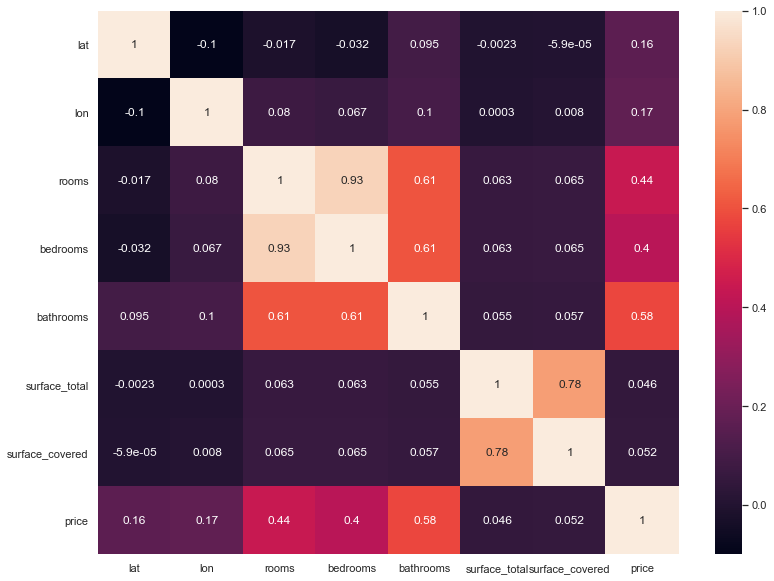

In [304]:
plt.figure(figsize=(13,10))
sns.heatmap(dataset.corr(), annot=True)
plt.show()

Podemos ver que los campos de habitaciones, ambientes, banos y ambos tipos de superficies estan altamente correlacionadas. Para algoritmos como Lasso (que se usara posteriormente), esto puede ser un problema. Esto lo resolveremos mediante el uso de la tecnica de PCA.

### Deteccion y eliminacion de valores atipicos

Dos metodos en particular se usaran en este analisis: rango intercuartil y 3 sigmas.
Primero haremos un analisis de las cantidades de registros que resultarian clasificadas como outliers usando ambos criterios.

In [305]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def detect_outliers(data, criteria='3sigma'):
    if criteria=='3sigma':
        data_mean = data.describe().loc['mean']
        data_std = data.describe().loc['std']
        criteria_max = data_mean + 3 * data_std
        criteria_min = data_mean - 3 * data_std
        return (data < criteria_min) | (data > criteria_max)
    if criteria=='iqr':
        q1 = np.quantile(data, 0.25)
        q3 = np.quantile(data, 0.75)
        iqr = q3 - q1
        return (data < q1 - iqr) | (data > q3 + iqr)

dataset_means = dataset.describe().loc['mean']
numeric_columns = dataset_means.index.values
outliers_in_dataset = pd.DataFrame(columns=['% IQR', '% sigmas'], index=numeric_columns)

for column in numeric_columns:
    outliers_3sigma = detect_outliers(dataset[column], criteria='3sigma')
    outliers_iqr = detect_outliers(dataset[column], criteria='iqr')
    
    iqr_number = np.round(100*outliers_iqr.sum()/dataset.shape[0], 2)
    sigma_number = np.round(100*outliers_3sigma.sum()/dataset.shape[0], 2)
    outliers_in_dataset.loc[column] = [iqr_number, sigma_number]

print(outliers_in_dataset)

                 % IQR % sigmas
lat               8.02     0.47
lon               5.07        0
rooms             1.53     1.53
bedrooms          0.66     0.66
bathrooms         3.28      0.9
surface_total    10.63     0.15
surface_covered  10.59      0.1
price            10.75     1.75


Estudiemos el caso de la superficie total para encontrar el motivo de la diferencia.

In [306]:
def compare_outlier_detection_for(column_name):
    print(f'======== {column_name} ========')
    outliers_summary = pd.DataFrame()

    outliers_3sigma_surface_total = detect_outliers(dataset[column_name], criteria='3sigma')
    outliers_summary['sigma'] = dataset[~outliers_3sigma_surface_total][column_name].describe()

    outliers_iqr_surface_total = detect_outliers(dataset[column_name], criteria='iqr')
    outliers_summary['iqr'] = dataset[~outliers_iqr_surface_total][column_name].describe()

    print(outliers_summary.loc[['max', 'min'], :], "\n")

In [307]:
for column in numeric_columns:
    compare_outlier_detection_for(column)

======== lat ========
         sigma        iqr
max -34.535909 -34.556087
min -34.668021 -34.640103 

======== lon ========
         sigma        iqr
max -58.353930 -58.362251
min -58.530468 -58.504268 

======== rooms ========
     sigma  iqr
max    6.0  6.0
min    1.0  1.0 

======== bedrooms ========
     sigma  iqr
max    5.0  5.0
min    0.0  0.0 

======== bathrooms ========
     sigma  iqr
max    4.0  3.0
min    1.0  1.0 

======== surface_total ========
      sigma    iqr
max  3070.0  171.0
min    13.0   13.0 

======== surface_covered ========
      sigma    iqr
max  1400.0  146.0
min     1.0    1.0 

======== price ========
         sigma       iqr
max  1230000.0  431000.0
min     6000.0    6000.0 



Podemos notar lo siguiente:

* Los campos con valores no consistentes con la realidad son: banos, superficie total y superficie cubierta.

* El criterio IQR muestra valores maximos que estan por debajo de lo que se ve en la realidad, por ejemplo, hay facilmente casas que superan los 170 m2. Deducimos que este criterio es muy agresivo en cuanto a la eliminacion de registros.

* El criterio de los 3 sigmas no elimina tantos registros (~0.2%), sin embargo, vemos que existen valores limites alejados de la realidad:
    
    * Existen registros con ningun bano. Por el tipo de inmuebles considerados en el analisis, deben tener al menos uno. Por ende se aplicara un filtrado `bathrooms > 0`.
    * Para las superficies totales y cubiertas:

        * El valor de maximo de 3.070m2 puede ser muy alto. Una busqueda rapida en [Argenprop](https://www.argenprop.com/casa-venta-localidad-capital-federal-desde-1000-m2) se puede notar que para inmuebles de mas de 1.000m2, se tienen mas de 6 habitaciones y precios cercanos a los 2.000.000 USD. Esto contradice los datos con los que contamos. Se aplicara un filtrado `surface_total <= 1000`.
        * El valor minimo de superficie de un [microdepartamento](https://www.infobae.com/tendencias/2018/10/09/micro-departamentos-adios-al-bidet-y-a-la-banera-en-las-viviendas-minimas-que-llegan-a-la-ciudad/) es de 18m2 considerandose un valor minimo razonable. Otro filtro a agregar seria `surface_covered >= 18`.
        * Para los microdepartamentos mencionados en el punto anterior, tambien se puede apreciar que el precio [esta a partir de los 39.000USD](https://www.cronista.com/negocios/Microdepartamentos-el-sueno-de-la-casa-propia-desde-us-50.000-20170325-0002.html) (tomando el precio de referencia de Liniers). Es necesaria la condicion `price >= 39000`.

El criterio escogido para usar sera el de las 3 sigmas. Posteriormente, se hara el filtrado mencionado en puntos anteriores.

In [308]:
print(f'Shape before processing {dataset.shape}')

# Eliminating outliers
for column in numeric_columns:
    columns_to_keep = ~detect_outliers(dataset[column], criteria='3sigma')
    dataset = dataset[columns_to_keep].copy()
    
print(f'Shape after processing {dataset.shape}')

Shape before processing (76163, 10)
Shape after processing (69683, 10)


In [309]:
print(f"Dimension antes: {dataset.shape}")
print(f"Registros invalidos: {dataset.query('surface_covered < 18 | surface_total > 1000 | bathrooms == 0 | price < 39000').shape[0]}")
dataset.query('surface_covered >= 18 & surface_total <= 1000 & bathrooms > 0 & price >= 39000', inplace=True)
print(f"Dimension despues: {dataset.shape}")

Dimension antes: (69683, 10)
Registros invalidos: 138
Dimension despues: (69545, 10)


In [310]:
dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0
6,-34.600988,-58.433061,Villa Crespo,2.0,1.0,1.0,70.0,70.0,PH,159500.0


### Encoding

Luego de la limpieza de los datos, empezamos con el proceso de codificacion del tipo de propiedad.

In [311]:
from sklearn.preprocessing import LabelEncoder

property_type_label_encoder = LabelEncoder()
dataset['property_type_encoded'] = property_type_label_encoder.fit_transform(dataset.property_type)

dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price,property_type_encoded
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0,2
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0,2
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0,2
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0,2
6,-34.600988,-58.433061,Villa Crespo,2.0,1.0,1.0,70.0,70.0,PH,159500.0,2


In [312]:
from sklearn.preprocessing import OneHotEncoder

property_type_one_hot_encoder = OneHotEncoder(sparse=False)
property_type_encoded = property_type_one_hot_encoder.fit_transform(dataset.property_type_encoded.to_numpy().reshape(-1, 1))
dataset = pd.concat([
    dataset.reset_index(drop=True),
    pd.DataFrame(property_type_encoded, columns=property_type_label_encoder.classes_)
], axis=1)
dataset.drop(['property_type_encoded'], axis=1, inplace=True)
dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price,Casa,Departamento,PH
0,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0,0.0,0.0,1.0
1,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0,0.0,0.0,1.0
2,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0,0.0,0.0,1.0
3,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0,0.0,0.0,1.0
4,-34.600988,-58.433061,Villa Crespo,2.0,1.0,1.0,70.0,70.0,PH,159500.0,0.0,0.0,1.0


Procedemos a realizar la particion del dataset.

**Nota:** Las columnas l3 y property_type continuaran en el dataset hasta luego del split ya que se usaran para el analisis de residuos.

In [313]:
from sklearn.model_selection import train_test_split

X = dataset.drop(['price'], axis=1)
y = dataset.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

Guardamos la informacion de `l3` y `property_type` para posterior analisis

In [314]:
label_columns = ['l3', 'property_type']

X_train_labels = X_train[label_columns].copy()
X_test_labels = X_test[label_columns].copy()

Eliminamos ahora estas columnas

In [315]:
X_train = X_train.drop(label_columns, axis=1).copy()
X_test = X_test.drop(label_columns, axis=1).copy()

In [316]:
X_train.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
46107,-34.584929,-58.411457,2.0,1.0,1.0,38.0,38.0,0.0,1.0,0.0
21789,-34.630911,-58.460848,4.0,3.0,1.0,74.0,68.0,0.0,1.0,0.0
39240,-34.549306,-58.477681,2.0,1.0,1.0,34.0,34.0,0.0,1.0,0.0
41159,-34.608248,-58.421008,2.0,1.0,1.0,52.0,48.0,0.0,1.0,0.0
68419,-34.599277,-58.381186,6.0,3.0,2.0,118.0,110.0,0.0,1.0,0.0


In [317]:
X_test.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
13066,-34.586709,-58.400602,1.0,1.0,1.0,38.0,31.0,0.0,1.0,0.0
4113,-34.562693,-58.465392,3.0,2.0,2.0,63.0,59.0,0.0,1.0,0.0
32279,-34.611445,-58.420994,1.0,1.0,1.0,28.0,18.0,0.0,1.0,0.0
21566,-34.587460,-58.386744,5.0,3.0,2.0,131.0,127.0,0.0,1.0,0.0
12828,-34.558095,-58.449723,2.0,1.0,1.0,30.0,29.0,0.0,1.0,0.0


**NOTA:** El conjunto de test se usara unicamente al final, luego de haber seleccionado el modelo para dar un estimado del desempeno real del modelo final.

### Escalado de datos

Para poder aplicar PCA de una forma mas efectiva, se procedera a hacer un escalado de datos.

In [318]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('scaler', StandardScaler(), ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'])
    ], remainder='passthrough')

X_train_new = pd.DataFrame(ct.fit_transform(X_train), columns=X_train.columns)
X_train_new.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
0,0.589892,0.700646,-0.779278,-0.978726,-0.648777,-0.867363,-0.878734,0.0,1.0,0.0
1,-1.451549,-0.708788,1.145925,1.326477,-0.648777,-0.127004,-0.027402,0.0,1.0,0.0
2,2.171396,-1.189132,-0.779278,-0.978726,-0.648777,-0.949625,-0.992244,0.0,1.0,0.0
3,-0.445400,0.428103,-0.779278,-0.978726,-0.648777,-0.579445,-0.594957,0.0,1.0,0.0
4,-0.047135,1.564480,3.071128,1.326477,1.014556,0.777879,1.164461,0.0,1.0,0.0


Le aplicamos este mismo escalado al conjunto de test

In [319]:
X_test_new = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)
X_test_new.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
0,0.510848,1.010423,-1.741880,-0.978726,-0.648777,-0.867363,-1.077377,0.0,1.0,0.0
1,1.577070,-0.838465,0.183323,0.173875,1.014556,-0.353225,-0.282802,0.0,1.0,0.0
2,-0.587321,0.428514,-1.741880,-0.978726,-0.648777,-1.073018,-1.446288,0.0,1.0,0.0
3,0.477511,1.405861,2.108527,1.326477,1.014556,1.045231,1.646882,0.0,1.0,0.0
4,1.781190,-0.391317,-0.779278,-0.978726,-0.648777,-1.031887,-1.134133,0.0,1.0,0.0


### Generacion de nuevas variables

Una vez escalados los datos, procedemos a aplicar PCA. Comenzamos generando tantos componentes como campos tiene el dataset.

In [320]:
from sklearn.decomposition import PCA

pca_total = PCA(n_components=X_train_new.shape[1], random_state=random_state)
pca_total.fit(X_train_new)

PCA(n_components=10, random_state=1996)

Tomaremos la decision de continuar con la cantidad de componentes que expliquen el 95% de variancia.

In [321]:
# For 95% of explained variance
cummulative_explained_variance = np.cumsum(pca_total.explained_variance_ratio_)
print(f'Cummulative explained variance:\n', cummulative_explained_variance * 100)
n_components = (cummulative_explained_variance < 0.95).sum() + 1
print(f'\nNumber of components {n_components} ({100 * cummulative_explained_variance[n_components-1]:.2f}%)')

Cummulative explained variance:
 [ 53.49781457  69.15184903  81.84237356  89.17800412  95.17843993
  97.55280479  98.84672266  99.70457112 100.         100.        ]

Number of components 5 (95.18%)


Procedemos a realizar la transformacion con la cantidad de componentes adecuada para el criterio tanto para el conjunto de train como el de test.

In [322]:
pca = PCA(n_components=n_components, random_state=random_state)
X_train_new = pca.fit_transform(X_train_new)
X_test_new = pca.transform(X_test_new)

### Estudio del nuevo desempeno del arbol de decision

La siguiente funcion, nos ayudara a resumir el estudio del modelo. Tiene las siguientes caracteristicas:

* Hace uso del metodo de cross validation (valor por defecto 5).
* La metrica a usar para el desempeno sera el RMSE.
* Mide el tiempo de entrenamiento para el modelo y los datos usados.

In [323]:
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

def study_model(model, data, cv=5, scoring="neg_root_mean_squared_error"):
    start = time()

    X_train, y_train = data
    
    model.fit(X_train, y_train)

    if cv is not None:
        score = -cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring).mean()
        print(f'{cv}-fold CV score for {type(model).__name__}: {score:.2f} USD')

    end = time()
    time_elapsed = end - start
    is_time_min = time_elapsed > 60
    if is_time_min:
        time_elapsed = time_elapsed / 60
    print(f"Time elapsed: {time_elapsed:0.4f} {'min' if is_time_min else 'sg'}")

In [324]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=9, random_state=random_state)
study_model(model=tree, data=(X_train_new, y_train))

5-fold CV score for DecisionTreeRegressor: 49725.51 USD
Time elapsed: 3.0170 sg


Se puede notar una reduccion del error de casi la mitad comparado con el analisis hecho en la parte 1.

# Parte B - Modelos Avanzados

### Eleccion de modelos

Para este estudio se usaran dos modelos: Lasso y RandomForest

### Lasso

Usaremos este modelo en conjunto con `PolynomialFeatures`. Con los parametros por defecto estudiamos el modelo usando un pipeline.

In [325]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

lasso_pipeline = make_pipeline(PolynomialFeatures(), Lasso(random_state=random_state, tol=1))

study_model(model=lasso_pipeline, data=(X_train_new, y_train))

5-fold CV score for Pipeline: 58158.79 USD
Time elapsed: 0.7725 sg


### Random Forest

A continuacion, realizamos un estudio similar con el modelo de Random Forest con los valores por defecto pero usando todos los procesadores.

In [326]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=random_state, n_jobs=-1)

study_model(model=forest, data=(X_train_new, y_train))

5-fold CV score for RandomForestRegressor: 32686.34 USD
Time elapsed: 51.8543 sg


Revisamos el bosque en busqueda de la profundidad promedio de los arboles. Podemos usar este valor como referencia para el paso de optimizacion de hiperparametros.

In [327]:
trees_depths = map(lambda tree: tree.get_depth(), forest.estimators_)
print(f'Trees depth: {int(np.round(sum(trees_depths)/len(forest.estimators_)))}')

Trees depth: 38


### Optimizacion de hiperparametros

La funcion `hyperparameter_optimization` nos ayudara a realizar la tarea en conjunto de entrenamiento y optimizacion de hiperparametros.

In [329]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats

def hyperparameter_optimization(model, params, data, strategy='random', n_iter=10, random_state=random_state, cv=5, scoring='neg_root_mean_squared_error'):
    search = None
    if strategy == 'grid':
        search = GridSearchCV(model, param_grid=params, cv=cv, scoring=scoring, n_jobs=-1)
    else:
        search = RandomizedSearchCV(model, param_distributions=params, cv=cv, scoring=scoring, n_jobs=-1, n_iter=n_iter, random_state=random_state)
    study_model(search, data, cv=None, scoring=scoring)
    print(f"Iterations: {n_iter}")
    print(f"Search strategy: {strategy}")
    print(f"Best params: {search.best_params_}")
    print(f"Best score ({cv}-fold CV): {-search.best_score_:0.2f} USD")
    return search

### Lasso

In [330]:
param_grid = {
    'polynomialfeatures__degree': stats.randint(low=1,high=8),
    'polynomialfeatures__include_bias': [True, False],
    'polynomialfeatures__interaction_only': [True, False],
    'lasso__alpha': stats.randint(low=1,high=20)
}
lasso_search = hyperparameter_optimization(model=lasso_pipeline, params=param_grid, data=(X_train_new, y_train), n_iter=20)

Time elapsed: 19.6847 sg
Iterations: 20
Search strategy: random
Best params: {'lasso__alpha': 8, 'polynomialfeatures__degree': 7, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': False}
Best score (5-fold CV): 53775.41 USD


### Random Forest

In [226]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'max_depth': stats.randint(low=25,high=50),
    'max_features': ['auto', 'sqrt', 'log2']
}
forest_search = hyperparameter_optimization(model=forest, params=param_distributions, data=(X_train_new, y_train), n_iter=20)

Time elapsed: 12.2309 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 49, 'max_features': 'log2', 'n_estimators': 169}
Best score (5-fold CV): 32178.08 USD


### Comparacion de modelos

Comparando los mejores scores de ambos modelos, el que resulta el ganador es Random Forest. Su error es casi el 60% del error de Lasso.
Procedemos ahora a evaluar este modelo con los datos de test para obtener el estimado del error en datos desconocidos.

In [333]:
from sklearn.metrics import mean_squared_error

y_test_pred = forest_search.predict(X_test_new)
error_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
error_train = -forest_search.best_score_
print(f'RMSE en test: {error_test:.2f} USD ({100 * (error_train - error_test) / error_train:.2f}% de diferencia de train)')

Se puede observar que el error obtenido en test es muy semejante al resultado del proceso de train con cross validation. Asi podemos pensar que el modelo se comportara de la forma esperada con datos nuevos.

# Parte C - Interpretacion de modelos

### Interpretacion de predictores

### Interpretacion de errores

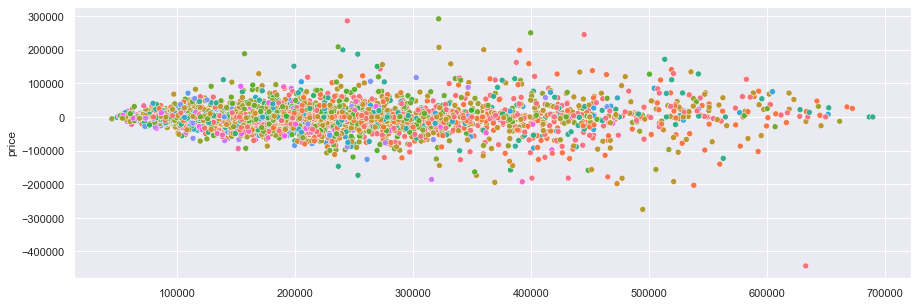

In [334]:
residuals = y_test - y_test_pred
plt.figure(figsize=(15,5))
sns.scatterplot(x=y_test_pred, y=residuals, hue=X_test_labels.l3, legend=False)
plt.show()

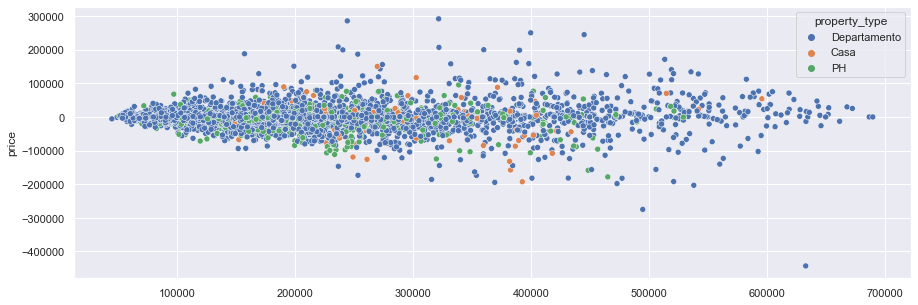

In [335]:
residuals = y_test - y_test_pred
plt.figure(figsize=(15,5))
sns.scatterplot(x=y_test_pred, y=residuals, hue=X_test_labels.property_type)
plt.show()

In [338]:
invalid_indexes = X_test[(np.abs(residuals) > 200000)].index
dataset.iloc[invalid_indexes]

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price,Casa,Departamento,PH
11153,-34.554294,-58.438676,Belgrano,2.0,1.0,2.0,145.0,131.0,Departamento,690000.0,0.0,1.0,0.0
33750,-34.623118,-58.433098,Caballito,4.0,3.0,2.0,160.0,130.0,Departamento,650000.0,0.0,1.0,0.0
37898,-34.619548,-58.428904,Caballito,5.0,3.0,2.0,117.0,110.0,Departamento,445000.0,0.0,1.0,0.0
52010,-34.573623,-58.421204,Palermo,3.0,2.0,2.0,82.0,70.0,Departamento,529000.0,0.0,1.0,0.0
43373,-34.581250,-58.406333,Barrio Norte,2.0,1.0,1.0,70.0,60.0,Departamento,530000.0,0.0,1.0,0.0
25984,-34.591492,-58.388038,Recoleta,4.0,3.0,3.0,168.0,147.0,Departamento,335000.0,0.0,1.0,0.0
46439,-34.618980,-58.445253,Caballito,4.0,3.0,2.0,128.0,120.0,Departamento,613567.0,0.0,1.0,0.0
21605,-34.558653,-58.446043,Belgrano,4.0,3.0,3.0,156.0,148.0,Departamento,190000.0,0.0,1.0,0.0
5581,-34.605458,-58.411002,Balvanera,5.0,3.0,3.0,200.0,186.0,Departamento,220000.0,0.0,1.0,0.0
